In [80]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy import stats
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Bidirectional, LeakyReLU, BatchNormalization, AveragePooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from ind_rnn import IndRNNCell,IndRNN
import os
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam



In [119]:

# Constants
WINDOW_LEN = 5400
N_FEATURE = 2

# Define the paths in a dictionary (for train, val, and test)
data_paths = {
    'train': [
        'F:/Tugas Akhir/Split_revisi_3-1/train/shuffled_1_train.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/train/shuffled_2_train.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/train/shuffled_3_train.npy',
    ],
    'val': [
        'F:/Tugas Akhir/Split_revisi_3-1/val/shuffled_1_val.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/val/shuffled_2_val.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/val/shuffled_3_val.npy',
    ],
    'test': [
        'F:/Tugas Akhir/Split_revisi_3-1/test/shuffled_1_test.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/test/shuffled_2_test.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/test/shuffled_3_test.npy',
    ]
}

# Function to load, process, and one-hot encode data
def load_and_process_data(data_paths):
    processed_data = {}
    
    for split in ['train', 'val', 'test']:
        x_data = []
        y_data = []
        
        # Load and concatenate data
        for path in data_paths[split]:
            data = np.load(path, allow_pickle=True)  # allow_pickle=True to load object arrays if needed
            # Mengakses fitur 'ear_x', 'mar_x', dan 'label'
            ear_x = data[:, :, 0]  # Semua window, semua elemen dalam window, kolom 0 (ear_x)
            mar_x = data[:, :, 1]  # Semua window, semua elemen dalam window, kolom 1 (mar_x)
            label = data[:, 0, 2]  # Semua window, label diambil dari elemen pertama
            
            # Combine 'ear_x' and 'mar_x' as features (combine along axis 1)
            features = np.stack((ear_x, mar_x), axis=-1)  # Shape: (samples, WINDOW_LEN, N_FEATURE)
            
            x_data.append(features)
            y_data.append(label)
        
        # Concatenate along the first axis (samples)
        x_data = np.vstack(x_data)
        y_data = np.concatenate(y_data)
        
        # One-hot encode the labels (0 -> [1, 0], 1 -> [0, 1])
        y_data = pd.get_dummies(y_data).values  # Shape: (num_samples, 2)
        
        # Store the processed data
        processed_data[split] = (x_data, y_data)
        
    return processed_data

# Load and process the data
processed_data = load_and_process_data(data_paths)

# Access the processed data
x_train, y_train = processed_data['train']
x_val, y_val = processed_data['val']
x_test, y_test = processed_data['test']

# Reshape the data to (samples, WINDOW_LEN, N_FEATURE)
x_train = x_train.reshape(-1, WINDOW_LEN, N_FEATURE)
x_val = x_val.reshape(-1, WINDOW_LEN, N_FEATURE)
x_test = x_test.reshape(-1, WINDOW_LEN, N_FEATURE)

# Check the shapes
print(f"Train data shape: {x_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation data shape: {x_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")


Train data shape: (213, 5400, 2), Train labels shape: (213, 3)
Validation data shape: (72, 5400, 2), Validation labels shape: (72, 3)
Test data shape: (93, 5400, 2), Test labels shape: (93, 3)


In [105]:
import numpy as np

# Ganti 'path_to_file.npy' dengan path file .npy Anda
file_path = 'F:/Tugas Akhir/Split_revisi_3-1/train/shuffled_1_train.npy'

# Membaca file npy
data = np.load(file_path)

# Melihat data
print("Data dari file:")
print(data)

# Menampilkan informasi data
print("\nTipe data:", type(data))
print("Shape data:", data.shape)
print("Data type elemen:", data.dtype)


Data dari file:
[[[0.72323275 0.25       1.        ]
  [0.79664585 0.25       1.        ]
  [0.79219614 0.25       1.        ]
  ...
  [0.69778602 0.25       1.        ]
  [0.67613709 0.25       1.        ]
  [0.69690189 0.25       1.        ]]

 [[0.73655329 0.25       1.        ]
  [0.73655329 0.25       1.        ]
  [0.73655329 0.25       1.        ]
  ...
  [0.67959638 0.29052244 1.        ]
  [0.67856085 0.27290928 1.        ]
  [0.67856085 0.27290928 1.        ]]

 [[0.78000367 0.25       1.        ]
  [0.8143596  0.25       1.        ]
  [0.7627898  0.25       1.        ]
  ...
  [0.76066949 0.25       1.        ]
  [0.76624173 0.25       1.        ]
  [0.79201174 0.25       1.        ]]

 ...

 [[0.70659101 0.25       1.        ]
  [0.77895792 0.27220861 1.        ]
  [0.70325153 0.3001392  1.        ]
  ...
  [0.7288498  0.31696236 1.        ]
  [0.73870356 0.31456016 1.        ]
  [0.7245837  0.32576281 1.        ]]

 [[0.92811641 0.25       1.        ]
  [0.92173357 0.25   

In [82]:
optimizers = Adam(learning_rate=0.0001)

def create_model():
    model = Sequential()
    
    # model.add(Bidirectional(IndRNN(32, return_sequences=True, kernel_regularizer=l2(1e-4)), 
    #                         input_shape=(WINDOW_LEN, N_FEATURE)))
    
    model.add(IndRNN(32, return_sequences=True, kernel_regularizer=l2(1e-6), 
                            input_shape=(WINDOW_LEN, N_FEATURE)))

    
    # Fully connected layers
    model.add(Flatten())  # Flatten the output from the CNN layers
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(8))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizers, metrics=['accuracy'], loss='categorical_crossentropy')
    
    return model

# Initialize the model
model = create_model()

# Optional: Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ind_rnn_2 (IndRNN)          (None, 5400, 32)          96        
                                                                 
 flatten_2 (Flatten)         (None, 172800)            0         
                                                                 
 dense_6 (Dense)             (None, 16)                2764816   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16)                0         
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8)                

In [83]:
# Define callbacks
model_checkpoint = ModelCheckpoint('./model_slide_window/IndRNNAug5400_Slide_revisi.h5', monitor='val_accuracy', 
                                   save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=800, verbose=1)

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=8, epochs=800, callbacks=[model_checkpoint, early_stopping])

np.save('./model_slide_window/training_history_5400_Slide_revisi.npy', history.history)

# Evaluate the model using the test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')


Epoch 1/800
27/27 [==============================] - ETA: 0s - loss: 1.5695 - accuracy: 0.3568
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to ./model_slide_window\IndRNNAug5400_Slide_revisi.h5
27/27 [==============================] - 19s 655ms/step - loss: 1.5695 - accuracy: 0.3568 - val_loss: 1.1204 - val_accuracy: 0.3333
Epoch 2/800
27/27 [==============================] - ETA: 0s - loss: 1.2875 - accuracy: 0.3099
Epoch 2: val_accuracy did not improve from 0.33333
27/27 [==============================] - 17s 616ms/step - loss: 1.2875 - accuracy: 0.3099 - val_loss: 1.1120 - val_accuracy: 0.3333
Epoch 3/800
27/27 [==============================] - ETA: 0s - loss: 1.1953 - accuracy: 0.3052
Epoch 3: val_accuracy did not improve from 0.33333
27/27 [==============================] - 17s 620ms/step - loss: 1.1953 - accuracy: 0.3052 - val_loss: 1.1023 - val_accuracy: 0.3333
Epoch 4/800
27/27 [==============================] - ETA: 0s - loss: 1.1863 - accuracy: 0.3286
Ep

3/3 - 1s - loss: 4.4263 - accuracy: 0.4409 - 598ms/epoch - 199ms/step
Test accuracy: 0.44086021184921265
Test loss: 4.42627477645874


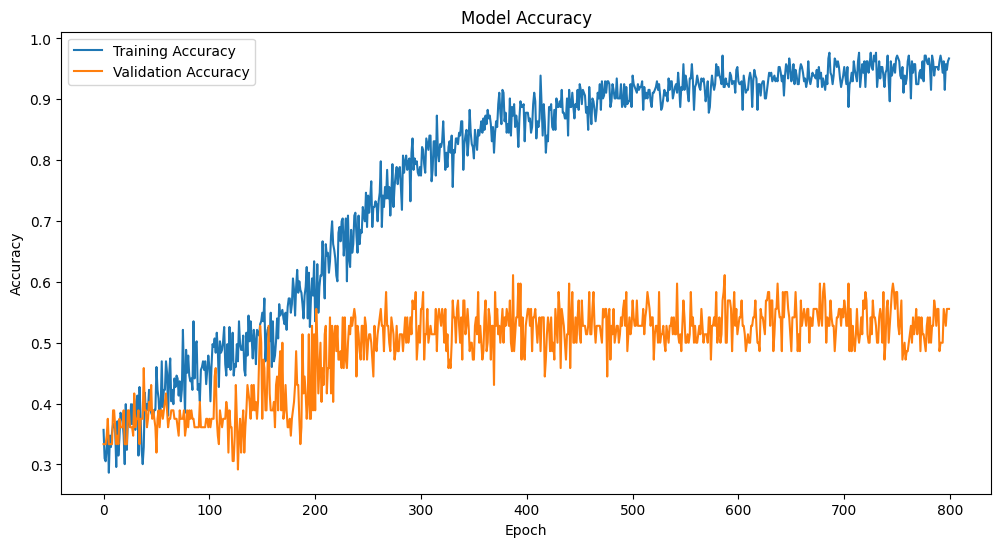

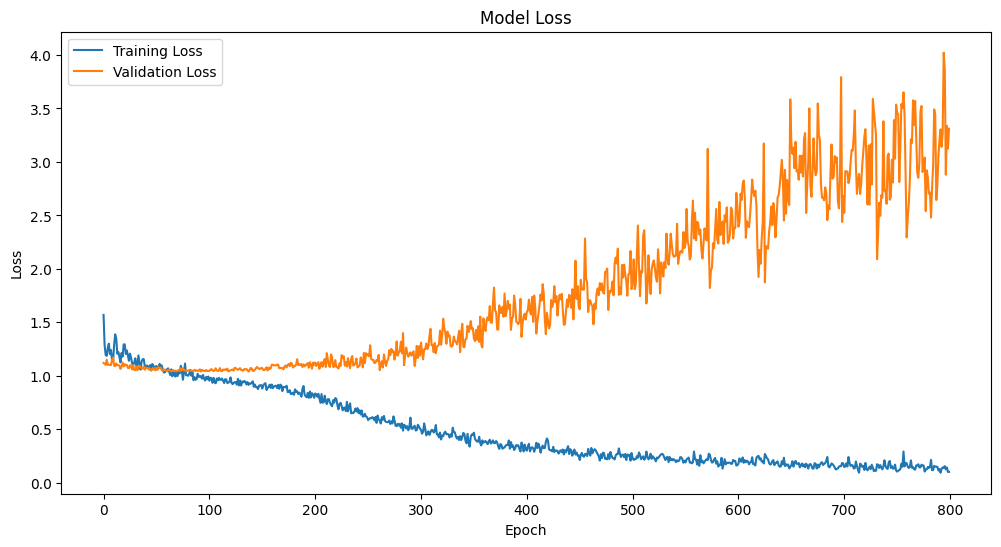

In [84]:
# Evaluate the model using the test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [128]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.regularizers import l2

# Set random seed for reproducibility
np.random.seed(3)
random.seed(3)
tf.random.set_seed(3)

# Load the saved model with custom object and compile it
model = load_model('./model_slide_window/IndRNNAug5400_Slide_revisi.h5', custom_objects={'IndRNN': IndRNN}, compile=False)

# Recompile the model with the same optimizer and loss
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


3/3 [==============================] - 1s 222ms/step - loss: 4.6726 - accuracy: 0.4731
Test Accuracy: 47.31%


In [130]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import random
import numpy as np
import tensorflow as tf
from ind_rnn import IndRNN
import os
assert os.path.exists('F:\Tugas Akhir\Itqan\model_slide_window/IndRNNAug5400_Slide_revisi.h5'), "File tidak ditemukan!"
import h5py

file_path = r'F:\Tugas Akhir\Itqan\model_slide_window/IndRNNAug5400_Slide_revisi.h5'

try:
    with h5py.File(file_path, 'r') as f:
        print("File .h5 berhasil dibuka dan valid.")
except Exception as e:
    print(f"File tidak valid atau korup: {e}")


def find_best_seed(model_path, x_test, y_test, custom_objects, seed_range):
    """
    Mencari seed terbaik berdasarkan akurasi model.

    Parameters:
    - model_path (str): Path ke model yang disimpan.
    - x_test (np.ndarray): Data uji (fitur).
    - y_test (np.ndarray): Data uji (label).
    - custom_objects (dict): Custom objects untuk load_model.
    - seed_range (list): Daftar seed yang ingin diuji.

    Returns:
    - best_seed (int): Seed terbaik berdasarkan akurasi tertinggi.
    - best_accuracy (float): Akurasi tertinggi.
    - results (dict): Dictionary dengan semua seed dan akurasi.
    """
    results = {}
    best_seed = None
    best_accuracy = 0.0

    for seed in seed_range:
        # Set random seed
        np.random.seed(seed)
        random.seed(seed)
        tf.random.set_seed(seed)
        
        # Load the saved model
        model = load_model(model_path, custom_objects=custom_objects, compile=False)
        
        # Recompile the model
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
        
        # Store the accuracy for the seed
        results[seed] = test_accuracy
        
        # Check if this seed gives the best accuracy
        if test_accuracy > best_accuracy:
            best_seed = seed
            best_accuracy = test_accuracy
        
        print(f"Seed {seed} - Test Accuracy: {test_accuracy:.4f}")
    
    return best_seed, best_accuracy, results

# Path ke file model
model_path = r'F:\Tugas Akhir\Itqan\model_slide_window/IndRNNAug5400_Slide_revisi.h5'

# Rentang seed yang ingin diuji
seed_range = range(0, 1000)  # Mencoba seed dari 0 hingga 50

# Muat model dengan custom objects
model = load_model(model_path, custom_objects={'IndRNN': IndRNN}, compile=False)

custom_objects={'IndRNN': IndRNN}

# Cari seed terbaik
best_seed, best_accuracy, results = find_best_seed(model_path, x_test, y_test, custom_objects, seed_range)

print("\nSeed terbaik:", best_seed)
print("Akurasi tertinggi: {:.2f}%".format(best_accuracy * 100))


File .h5 berhasil dibuka dan valid.
Seed 0 - Test Accuracy: 0.4731
Seed 1 - Test Accuracy: 0.4624
Seed 2 - Test Accuracy: 0.4194
Seed 3 - Test Accuracy: 0.4731
Seed 4 - Test Accuracy: 0.4301
Seed 5 - Test Accuracy: 0.3226
Seed 6 - Test Accuracy: 0.3548
Seed 7 - Test Accuracy: 0.3978
Seed 8 - Test Accuracy: 0.4301
Seed 9 - Test Accuracy: 0.4409
Seed 10 - Test Accuracy: 0.3333
Seed 11 - Test Accuracy: 0.3548
Seed 12 - Test Accuracy: 0.4516
Seed 13 - Test Accuracy: 0.4624
Seed 14 - Test Accuracy: 0.4516
Seed 15 - Test Accuracy: 0.4194
Seed 16 - Test Accuracy: 0.4301
Seed 17 - Test Accuracy: 0.4194
Seed 18 - Test Accuracy: 0.4731
Seed 19 - Test Accuracy: 0.4301
Seed 20 - Test Accuracy: 0.3978
Seed 21 - Test Accuracy: 0.4624
Seed 22 - Test Accuracy: 0.4086
Seed 23 - Test Accuracy: 0.4516
Seed 24 - Test Accuracy: 0.4946
Seed 25 - Test Accuracy: 0.3978
Seed 26 - Test Accuracy: 0.4624
Seed 27 - Test Accuracy: 0.4516
Seed 28 - Test Accuracy: 0.3871
Seed 29 - Test Accuracy: 0.3656
Seed 30 - Test

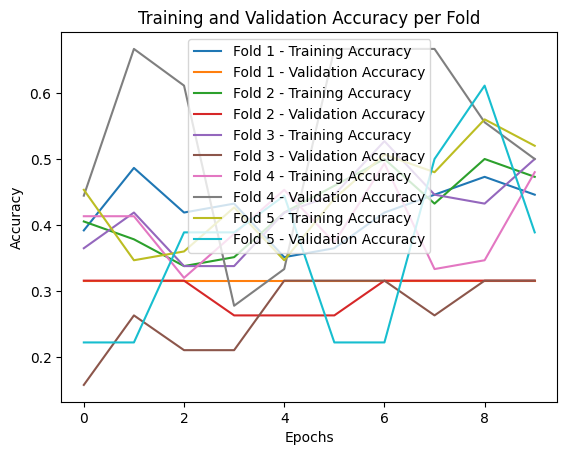

Akurasi untuk setiap fold: [0.31578946113586426, 0.31578946113586426, 0.31578946113586426, 0.5, 0.3888888955116272]
Rata-rata akurasi: 0.367251455783844


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load the saved model with custom objects and compile it
model_path = './model_slide_window/IndRNNAug5400_Slide_revisi.h5'
custom_objects = {'IndRNN': IndRNN}  # Sesuaikan jika ada objek khusus lainnya
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store scores and histories
scores = []
histories = []

# Manual cross-validation with history tracking
for fold, (train_index, test_index) in enumerate(kfold.split(x_test, y_test), 1):
    # Load and compile model for each fold
    model = load_model(model_path, custom_objects=custom_objects, compile=False)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Split data into training and validation sets for this fold
    x_train_fold, x_val_fold = x_test[train_index], x_test[test_index]
    y_train_fold, y_val_fold = y_test[train_index], y_test[test_index]

    # Train the model and record the history
    history = model.fit(
        x_train_fold, y_train_fold, 
        validation_data=(x_val_fold, y_val_fold), 
        epochs=10, batch_size=8, verbose=0  # Sesuaikan epoch dan batch size jika diperlukan
    )
    
    # Save accuracy score and history
    score = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    scores.append(score[1])  # Akurasi dari evaluasi
    histories.append(history.history)  # Menyimpan seluruh data history

    # Visualize accuracy per epoch for this fold
    plt.plot(history.history['accuracy'], label=f'Fold {fold} - Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'Fold {fold} - Validation Accuracy')

# Final plot customization
plt.title("Training and Validation Accuracy per Fold")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Print average accuracy across all folds
print("Akurasi untuk setiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))


x_train original shape: (213, 5400, 2)
Train data shape: (213, 5400, 2), Train labels shape: (213, 3)
Validation data shape: (72, 5400, 2), Validation labels shape: (72, 3)
Test data shape: (93, 5400, 2), Test labels shape: (93, 3)
Unique labels in train set: [0 1 2]
Unique labels in validation set: [0 1 2]
Unique labels in test set: [0 1 2]
Jumlah label kelas 0: 71, Jumlah label kelas 1: 71
3/3 [==============================] - 1s 175ms/step


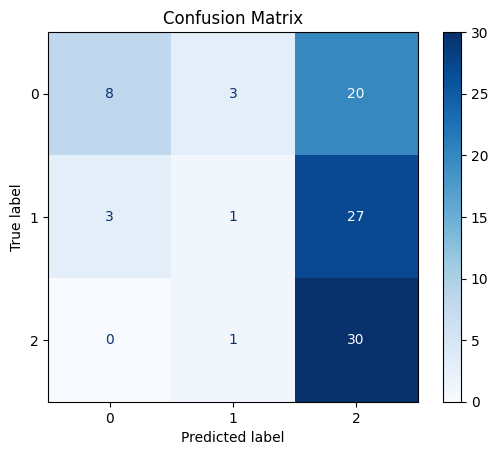

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ind_rnn import IndRNN  # Pastikan library IndRNN tersedia atau implementasikan sesuai kebutuhan

# Constants
WINDOW_LEN = 5400
N_FEATURE = 2

# Define the paths in a dictionary (for train, val, and test)
data_paths = {
    'train': [
        'F:/Tugas Akhir/Split_revisi_3-1/train/shuffled_1_train.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/train/shuffled_2_train.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/train/shuffled_3_train.npy',
    ],
    'val': [
        'F:/Tugas Akhir/Split_revisi_3-1/val/shuffled_1_val.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/val/shuffled_2_val.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/val/shuffled_3_val.npy',
    ],
    'test': [
        'F:/Tugas Akhir/Split_revisi_3-1/test/shuffled_1_test.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/test/shuffled_2_test.npy',
        'F:/Tugas Akhir/Split_revisi_3-1/test/shuffled_3_test.npy',
    ]
}

# Function to load, process, modify labels, and apply one-hot encoding
def load_and_process_data(data_paths):
    processed_data = {}
    
    for split in ['train', 'val', 'test']:
        x_data = []
        y_data = []
        
        # Load and concatenate data
        for path in data_paths[split]:
            data = np.load(path, allow_pickle=True)  # allow_pickle=True to load object arrays if needed
            # Mengakses fitur 'ear_x', 'mar_x', dan 'label'
            ear_x = data[:, :, 0]  # Semua window, semua elemen dalam window, kolom 0 (ear_x)
            mar_x = data[:, :, 1]  # Semua window, semua elemen dalam window, kolom 1 (mar_x)
            label = data[:, 0, 2]  # Semua window, label diambil dari elemen pertama
            
            # Combine 'ear_x' and 'mar_x' as features (combine along axis 1)
            features = np.stack((ear_x, mar_x), axis=-1)  # Shape: (samples, WINDOW_LEN, N_FEATURE)
            
            x_data.append(features)
            y_data.append(label)
        
        # Concatenate along the first axis (samples)
        x_data = np.vstack(x_data)
        y_data = np.concatenate(y_data)
        
        # One-hot encode the labels (0 -> [1, 0], 1 -> [0, 1])
        y_data = pd.get_dummies(y_data).values  # Shape: (num_samples, 2)
        
        # Store the processed data
        processed_data[split] = (x_data, y_data)
        
    return processed_data

# Load and process the data
processed_data = load_and_process_data(data_paths)

# Access the processed data
x_train, y_train = processed_data['train']
x_val, y_val = processed_data['val']
x_test, y_test = processed_data['test']

print(f"x_train original shape: {x_train.shape}")


# Reshape the data to (samples, WINDOW_LEN, N_FEATURE)
x_train = x_train.reshape(-1, WINDOW_LEN, N_FEATURE)
x_val = x_val.reshape(-1, WINDOW_LEN, N_FEATURE)
x_test = x_test.reshape(-1, WINDOW_LEN, N_FEATURE)

# Check the shapes and label values
print(f"Train data shape: {x_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation data shape: {x_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")

# Display unique labels in each dataset (after one-hot encoding)
print(f"Unique labels in train set: {np.unique(np.argmax(y_train, axis=1))}")
print(f"Unique labels in validation set: {np.unique(np.argmax(y_val, axis=1))}")
print(f"Unique labels in test set: {np.unique(np.argmax(y_test, axis=1))}")

label_counts = np.sum(y_train, axis=0)
print(f"Jumlah label kelas 0: {label_counts[0]}, Jumlah label kelas 1: {label_counts[1]}")

# Set random seed for reproducibility
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

# 1. Load the trained model
model = load_model('F:/Tugas Akhir/Itqan/model_slide_window/IndRNNAug5400_Slide_revisi.h5', custom_objects={'IndRNN': IndRNN}, compile=False)  # Pastikan model sudah dilatih dan disimpan

# 2. Make predictions on the test set
y_pred_prob = model.predict(x_test)  # Prediksi probabilitas
y_pred = np.argmax(y_pred_prob, axis=1)  # Get class with highest probability

# 3. Convert one-hot encoded labels to class labels (if necessary)
y_test_labels = np.argmax(y_test, axis=1)

# 4. Generate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# 5. Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(y_test.shape[1])])  # Use the number of classes in y_test
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
